In [2]:
#%matplotlib inline
import os
import sys
import re
from pprint import pprint
from decimal import Decimal
import os.path as op
from IPython.display import Image
import matplotlib.pyplot as plt
from typing import Iterator, Tuple, List, Dict
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import contextlib
import doctest

with contextlib.redirect_stdout(None):
  print("This won't print!")

In [3]:
long_calc_path = '/home/legha/bin/Version5_ev1738/Dragon/Linux_x86_64/msca'
with open(op.join(long_calc_path, 'CGN_PIN_A.result')) as f:
    long_str = f.read()

short_calc_path = '/home/legha/bin/Version5_ev1738/Dragon/msca/output_short'
with open(op.join(short_calc_path, 'CGN_PIN_A_short.result')) as f:
    short_str = f.read()

In [4]:
end='.*\n'
line=[m.end() for m in re.finditer(end, long_str)]

with contextlib.redirect_stdout(None):
    pattern = '>\|(BURNUP step \d+.*?)(?=>\|BURNUP step|>\|CGN_PIN_A completed)'
    match=re.compile(pattern, re.MULTILINE|re.DOTALL)
    for m in re.finditer(match, long_str):
        lineno = next(i+1 for i in range(len(line)) if line[i]>m.start(1))
        endno = lineno + len(m.group().splitlines()) - 1
        text = m.group()[:70]
        print(f'lineno start:{lineno: <6} end:{endno: <6} text: {text}')

In [5]:
def parse_echo(s : str)-> Iterator[str]:
    """
    Parse ECHO statements from dragon 5 output
    
    >>> next(parse_echo('\\n>|BURNUP step 1 between  0.000000e+00 and  7.692308e-01 day:              |>0131\\n'))
    'start:2      end:2      text: >|BURNUP step 1 between  0.000000e+00 and  7.692308e-01 day:              '
    """
    
    end='.*\n'
    line=[m.end() for m in re.finditer(end, s)]

    pattern = '>\|(.*?)(?=\|>\d+)'
    match=re.compile(pattern, re.MULTILINE|re.DOTALL)
    for m in re.finditer(match, s):
        lineno = next(i+1 for i in range(len(line)) if line[i]>m.start(1))
        endno = lineno + len(m.group().splitlines()) - 1
        text = m.group()
        yield f'start:{lineno: <6} end:{endno: <6} text: {text}'
    else:
        yield ''
        
for i in parse_echo(short_str): print(i)
doctest.testmod()

start:7999   end:7999   text: >|STARTING WHILE                                                          
start:8007   end:8007   text: >|istep 1 step2  3.000000e+01                                             
start:8008   end:8008   text: >|BURNUP step 1 between  0.000000e+00 and  7.692308e-01 day:              
start:8337   end:8337   text: >|StepAuto:  3.000000e+01 MWj/t                                           
start:8338   end:8338   text: >|Self-shielding calculation 1 at  7.692308e-01 DAY:                      
start:9567   end:9567   text: >|step2=  3.000000e+01 evoend=  7.692308e-01                              
start:12916  end:12916  text: >|BURNUP:   3.000000e+01   <-> K-INFINITY :   1.055019e+00                
start:12955  end:12955  text: >|THIS IS BEFORE STEP increase  1                                         
start:12956  end:12956  text: >|THIS IS AFTER STEP increase  2                                          
start:12957  end:12957  text: >|STARTING WHILE         

TestResults(failed=0, attempted=1)

In [6]:
def parse_burnup_vs_kinf(s: str, debug: bool = False)-> List[Tuple[Decimal, Decimal]]:
    """
    Parse ECHO dragon statement to extract values for BURNUP and K-INFINITY
    
    >>> s = '\\n>|BURNUP:   3.000000e+01   <-> K-INFINITY :   1.055019e+00                |>0173\\n'
    >>> parse_burnup_vs_kinf(s)
    [(Decimal('30.00000'), Decimal('1.055019'))]
    """
    
    end='.*\n'
    line=[m.end() for m in re.finditer(end, s)]
    
    burn_vs_kinf = [] # save burnup vs kinf in list

    pattern = r'''>\|(BURNUP:(?P<burnup>.*?)<-> K-INFINITY :(?P<kinf>.*?))(?=\|>\d+)'''
    match=re.compile(pattern, re.MULTILINE | re.DOTALL)
    for m in re.finditer(match, s):
        lineno = next(i+1 for i in range(len(line)) if line[i]>m.start(1))
        endno = lineno + len(m.group().splitlines()) - 1
        text = m.group()
        burnup = Decimal(m.group("burnup").strip())
        kinf = Decimal(m.group("kinf").strip())
        print(f'''start:{lineno: <6} end:{endno: <6} burnup: {float(burnup)} kinf: {float(kinf)} text: {text}''') if debug else None
        burn_vs_kinf.append((burnup, kinf))
        
    return burn_vs_kinf

doctest.testmod()

TestResults(failed=0, attempted=3)

In [8]:
burnup_vs_kinf = parse_burnup_vs_kinf(short_str, debug=True)

start:12916  end:12916  burnup: 30.0 kinf: 1.055019 text: >|BURNUP:   3.000000e+01   <-> K-INFINITY :   1.055019e+00                
start:17867  end:17867  burnup: 50.0 kinf: 1.049796 text: >|BURNUP:   5.000000e+01   <-> K-INFINITY :   1.049796e+00                
start:22817  end:22817  burnup: 75.0 kinf: 1.047678 text: >|BURNUP:   7.500000e+01   <-> K-INFINITY :   1.047678e+00                


/home/legha/bin/miniconda3/envs/jupyter/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


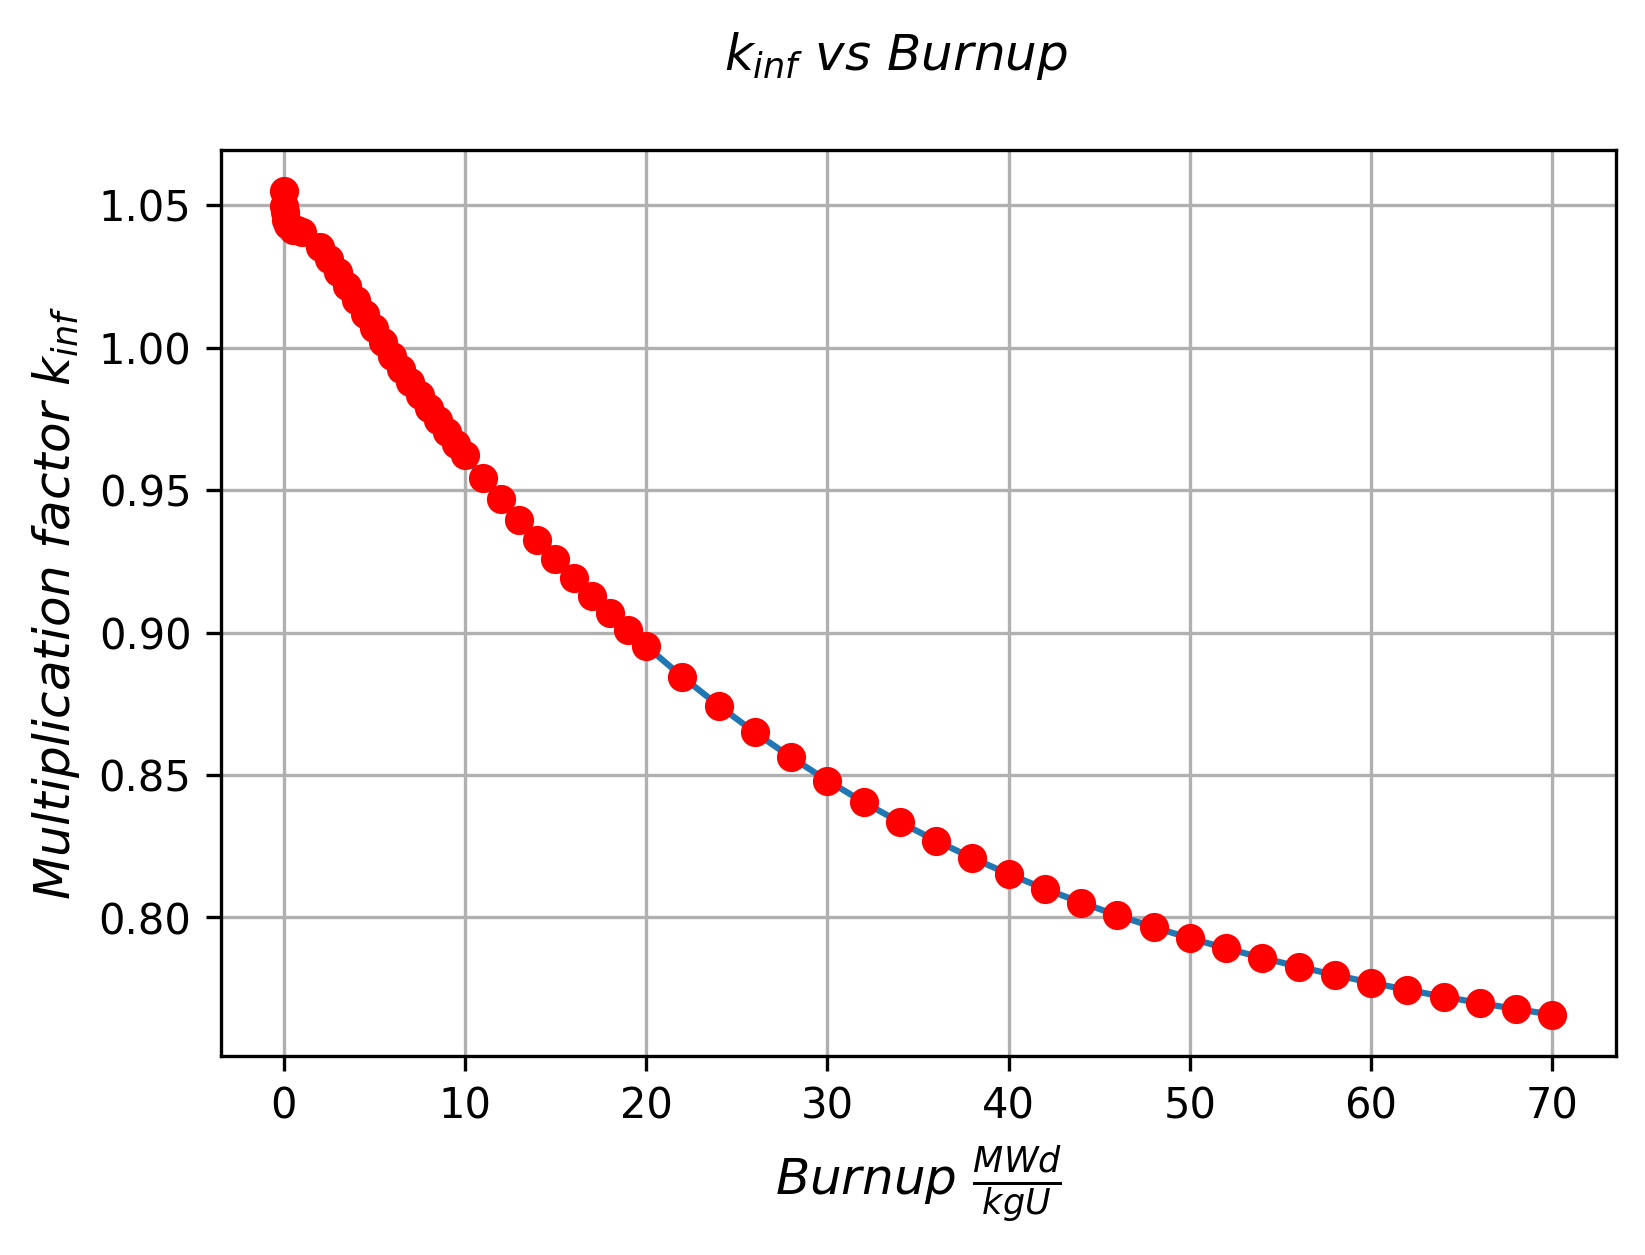

In [9]:
def plot_burnup_vs_kinf(data: List[Tuple[Decimal, Decimal]])-> Image:
    x_val = [x[0]/1000 for x in data]
    y_val = [x[1] for x in data]
    
    fig = plt.figure()
    plt.grid()
    plt.plot(x_val,y_val)
    plt.plot(x_val,y_val,'or')
    plt.suptitle('$k_{inf} \ vs \ Burnup$', fontsize=12)
    plt.xlabel(r'$Burnup \ \frac{MWd}{kgU}$', fontsize=12)
    plt.ylabel(r'$Multiplication \ factor \ k_{inf}$', fontsize=12)
    filename = 'kinf_vs_burnup.png'
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    #plt.show()
    plt.close(fig)
    return Image(filename, width=600, height=600)


burnup_vs_kinf = parse_burnup_vs_kinf(long_str)
plot_burnup_vs_kinf(data=burnup_vs_kinf)

In [10]:
def get_burnup_step_data(s: str, debug: bool = False) -> Iterator[Tuple[str, str]]:
    end='.*\n'
    line=[m.end() for m in re.finditer(end, s)]

    pattern = '>\|(BURNUP step (?P<step>\d+).*?)(?=>\|BURNUP step|>\|CGN_PIN_A completed)'
    match=re.compile(pattern, re.MULTILINE|re.DOTALL)
    for m in re.finditer(match, s):
        lineno = next(i+1 for i in range(len(line)) if line[i]>m.start(1))
        endno = lineno + len(m.group().splitlines()) - 1
        text = m.group()
        step = m.group('step')
        print(f'lineno start:{lineno: <6} end:{endno: <6} step: {step} text: {text[:70]}') if debug else None
        yield step, text
        
for step, text in get_burnup_step_data(long_str, debug=True):
    print(step)
    print(text)
    #parse_burnup_vs_kinf(text)
    break

lineno start:8117   end:13070  step: 1 text: >|BURNUP step 1 between  0.000000e+00 and  7.692308e-01 day:          
1
>|BURNUP step 1 between  0.000000e+00 and  7.692308e-01 day:              |>0243
->@BEGIN MODULE : EVO:        
->@DESCRIPTION  : Isotopic depletion and fuel burnup                                      
->@CREDITS      : A. Hebert                                                               
->@COPYRIGHTS   : ECOLE POLYTECHNIQUE DE MONTREAL  
                  GNU LESSER GENERAL PUBLIC LICENSE

 EVODRV: NUMBER OF FISSILE ISOTOPES=  19
         NUMBER OF FISSION PRODUCTS= 207

 EVODRV:  FUEL INITIAL DENSITY   =   8.862191E+00 G/CC
          FUEL TOTAL VOLUME      =   5.270718E-01 CC
          FUEL INITIAL MASS      =   4.671011E+00 G
          FUEL INITIAL MASS/CELL VOL =   2.942184E+00 G/CC

 EVODRV: SAVE INFORMATION RELATED TO TIME  0.0000E+00 E+8 S (  0.0000E+00 DAY) ON LCM DIRECTORY NAMED 'DEPL-DAT0001'.

 EVOSIG: flux level  =  4.0435E+14 n/cm^2/s.

 EVODRV: SOLUTI

In [11]:
def get_iso_density_per_ring(s: str, debug: bool = False) -> List[Tuple[str, str, Decimal]]:
    iso_data = []
    for iso in ['Pu239', 'U235', 'Pu241']:
        pattern = (
            '(?<=ISOTOPIC DENSITIES AFTER BURNUP FOR MIXTURE =)\s+?(?P<ring>\d+)\s\(10\*\*24 PARTICLES/CC\)' # look behind and find ISOTOPIC DENSITIES string
            '.*?' # some data
            f'{iso}\s+:[\s=]+(?P<density>[+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))' # iso name followed by : and float number
        )
        prog = re.compile(pattern, re.MULTILINE | re.DOTALL)
        for m in re.finditer(prog, s):
            ring = m.group('ring')
            density = Decimal(m.group('density'))
            # print(m.group())
            print(f'iso: {iso: <5} ring: {ring: <2} dens: {density: <10}') if debug else None
            iso_data.append((iso, ring, density))
    return iso_data


In [16]:
def get_iso_dens_vs_burnup(s: str, debug: bool = False) -> Dict[Decimal, List[Tuple[str, str, Decimal]]]:
    iso_dens_vs_burnup = {}
    for burnup_step, burnup_step_text in get_burnup_step_data(long_str, debug=debug):
        print(burnup_step, burnup_step_text[:70] + '...') if debug else None
        iso_data = get_iso_density_per_ring(burnup_step_text, debug=debug)
        burnup_value = parse_burnup_vs_kinf(burnup_step_text, debug=debug)[0][0]
        print(f'burnup_step: {burnup_step} burnup_value: {burnup_value} iso_data: {iso_data}') if debug else None
        iso_dens_vs_burnup[burnup_value] = iso_data
    return iso_dens_vs_burnup

iso_dens_vs_burnup = get_iso_dens_vs_burnup(short_str, debug=False)

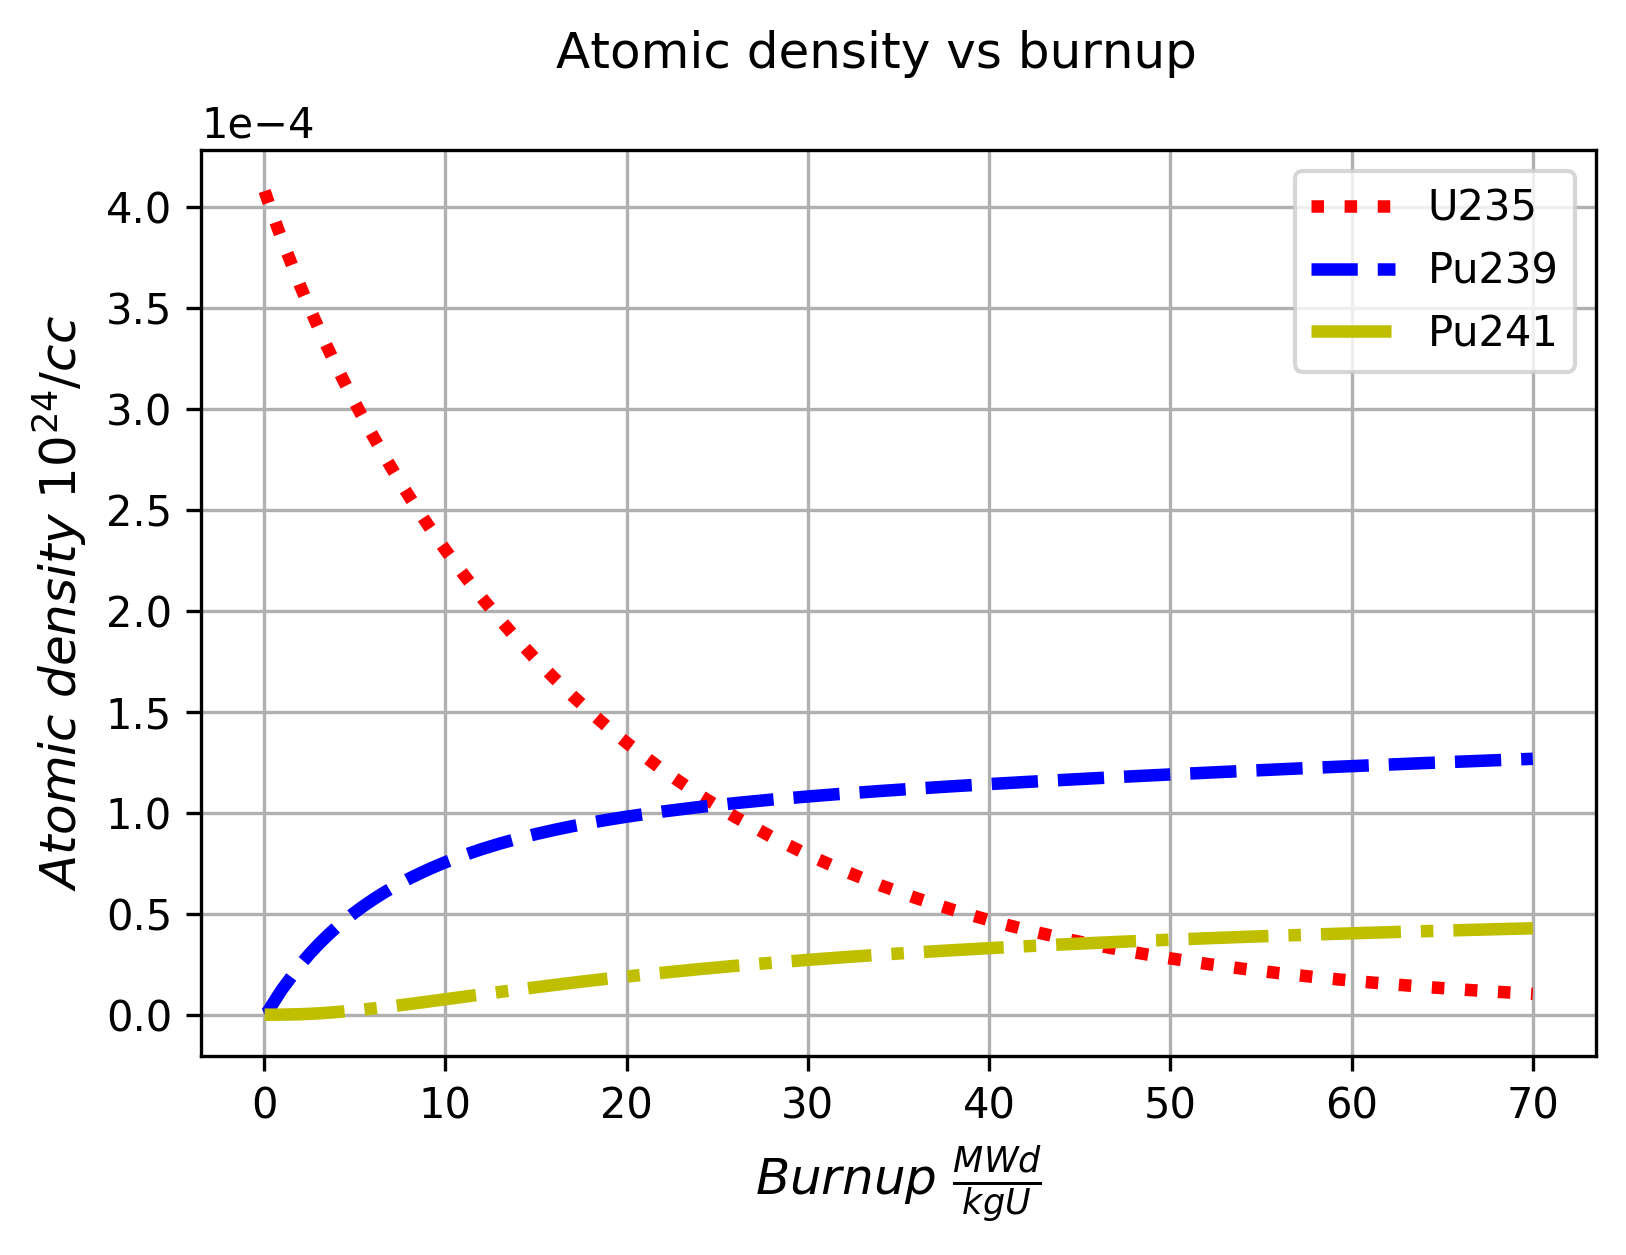

In [15]:
def plot_atomic_dens_vs_burnup(d: Dict[Decimal, List[Tuple[str, str, Decimal]]]) -> Image:
    burnup = [ k/1000 for k in iso_dens_vs_burnup.keys()]
    pu239 = [v[0][2] for _, v in iso_dens_vs_burnup.items() if v[0][0]=='Pu239']
    u235 = [v[4][2] for _, v in iso_dens_vs_burnup.items() if v[4][0]=='U235']
    pu241 = [v[8][2] for _, v in iso_dens_vs_burnup.items() if v[8][0]=='Pu241']
    
    fig = plt.figure()
    plt.plot(burnup,u235, label='U235', linestyle=':', color='r', linewidth=3) # dotted
    plt.plot(burnup,pu239, label='Pu239', linestyle='--', color='b', linewidth=3) # dashed
    plt.plot(burnup,pu241, label='Pu241', linestyle='-.', color='y', linewidth=3) # dashdot
    plt.legend(loc='upper right')
    plt.grid()
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=True))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    plt.suptitle('Atomic density vs burnup', fontsize=12)
    plt.xlabel(r'$Burnup \ \frac{MWd}{kgU}$', fontsize=12)
    plt.ylabel(r'$Atomic \ density \ 10^{24}/cc$', fontsize=12)
    filename = 'atomic_dens_vs_burnup.png'
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.show()
    plt.close(fig)
    return Image(filename, width=500, height=500)
   
plot_atomic_dens_vs_burnup(d=iso_dens_vs_burnup)

In [ ]:
def convert_view_execute()-> None:
    get_ipython().system('jupyter nbconvert parse.ipynb --to python')
    get_ipython().system('cat parse.py')
    get_ipython().run_line_magic('run', 'parse.py')

In [21]:
def check_mypy()-> None:
    get_ipython().system('jupyter nbconvert parse.ipynb --to python')
    get_ipython().system('mypy parse.py')
check_mypy()

[NbConvertApp] Converting notebook parse.ipynb to python
[NbConvertApp] Writing 8301 bytes to parse.py
parse.py:14: error: No library stub file for module 'IPython.display'
parse.py:14: note: (Stub files are from https://github.com/python/typeshed)
parse.py:15: error: No library stub file for module 'matplotlib.pyplot'
parse.py:15: error: No library stub file for module 'matplotlib'
parse.py:17: error: No library stub file for module 'matplotlib.ticker'
parse.py:77: error: "print" does not return a value
parse.py:160: error: "print" does not return a value
parse.py:192: error: "print" does not return a value
parse.py:206: error: "print" does not return a value
parse.py:247: error: Name 'get_ipython' is not defined
parse.py:248: error: Name 'get_ipython' is not defined
parse.py:249: error: Name 'get_ipython' is not defined
parse.py:256: error: Name 'get_ipython' is not defined
parse.py:257: error: Name 'get_ipython' is not defined
Found 13 errors in 1 file (checked 1 source file)
